In [218]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [219]:
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

def sigmoid_derivative(x):
    return x * (1.0 - x)

def filtering(arr, n0 = 3):
    arr = arr[:(len(arr) // n0) * n0]
    return np.mean(arr.reshape(-1, n0) , axis = 1)

In [220]:
#class for a NN with one hidden layer with 4 neurons (?)
class NeuralNetwork:
    #initialize neural network
    def __init__(self, x, y, n, alpha = 0.05):
        #public:
        self.input = x
        if len(y.shape) == 1:
            self.y  = y.reshape(-1,1)
        else:
            self.y = y
        
            
        self.learning_rate = alpha
        #private:
        self.__neurons  = n
        self.__output   = np.zeros(self.y.shape)
        self.__weights1 = np.random.rand(self.__neurons,self.input.shape[1])
        self.__weights2 = np.random.rand(1,self.__neurons)
    
    #reset neural network
    def reset(self):
        self.__init__(self.input,self.y)
        
    def getoutput(self):
        return self.__output
    
    def set_y(self, y):
        if len(y.shape) == 1:
            self.y  = y.reshape(-1,1)
        else:
            self.y = y
        
    #feedforward with zero bias (b2=0)
    def feedforward(self):
        self.layer1   = sigmoid(self.input @ self.__weights1.T)
        self.__output = sigmoid(self.layer1 @ self.__weights2.T)      
    
    #backpropagation algorithm (Andrew NG)
    def backpropagation(self,l_reg):
        #compute "error" for each layer
        d_weights_output = (self.y - self.__output) 
        d_weights_hidden = (d_weights_output @ self.__weights2) * sigmoid_derivative(self.layer1)
        #d_weights_input  = (d_weights_hidden @ self.__weights1) * sigmoid_derivative(self.input)
        
        
        #update weights
        self.__weights1 = self.__weights1 + self.learning_rate * (d_weights_hidden.T @ self.input) / self.y.size + \
        l_reg * self.__weights1
        self.__weights2 = self.__weights2 + self.learning_rate * (d_weights_output.T @ self.layer1) / self.y.size + \
        l_reg * self.__weights2

In [221]:
## input
df = pd.read_csv("C:\\Users\\unieuro\\Documents\\ML\\WondrousMachineLaundry-master\\titanic\\data\\train.csv")

## mapping strings to numbers
df["Sex"] = df["Sex"].replace({"male":0, "female":1})
df["Embarked"] = df["Embarked"].replace({'C':0, 'S':1, 'Q':2})

## handling names
title_dict = {"Mr.":0, "Mrs.":1, "Mme.":1, "Miss.":2, "Mlle.":2, "Master.":3, "Dr.":4, "Rev.": 5}
for i_row, row in df.iterrows():
    name_str = row["Name"]
    if not isinstance(name_str, str):
        break # break the loop if the names have already been replaced by ints
    df.loc[i_row,"Name"] = 6 # assign the default value at the begining
    for word in name_str.split():
        if word in title_dict.keys():
            df.loc[i_row,"Name"] = title_dict[word]
            break # break the loop if the key value has been found
        
## handling nans
df = df.drop(columns=["Cabin"])
df["Age"] = df["Age"].fillna(df["Age"].median())
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode().iloc[0])

## get dummies
features = ["Pclass", "Name"]
for f in features:
    df = pd.concat([df.drop(columns=f), pd.get_dummies(df[f], prefix=f)], axis=1)

## creating input and output dataframes
yf = df["Survived"]
Xf = df.drop(columns=["PassengerId", "Survived", "Ticket"])

## normalizing
features = ["Age", "Fare"]
Xf[features] = (Xf[features] - Xf[features].mean()) / Xf[features].std()
print(Xf.head())

   Sex       Age  SibSp  Parch      Fare  Embarked  Pclass_1  Pclass_2  \
0    0 -0.565419      1      0 -0.502163       1.0         0         0   
1    1  0.663488      1      0  0.786404       0.0         1         0   
2    1 -0.258192      0      0 -0.488580       1.0         0         0   
3    1  0.433068      1      0  0.420494       1.0         1         0   
4    0  0.433068      0      0 -0.486064       1.0         0         0   

   Pclass_3  Name_0  Name_1  Name_2  Name_3  Name_4  Name_5  Name_6  
0         1       1       0       0       0       0       0       0  
1         0       0       1       0       0       0       0       0  
2         1       0       0       1       0       0       0       0  
3         0       0       1       0       0       0       0       0  
4         1       1       0       0       0       0       0       0  


In [222]:
Xdata=Xf.loc[:,:].to_numpy()
ydata=yf.loc[:].to_numpy()

In [223]:
from sklearn.model_selection import train_test_split
neurons = 10
l_reg = -0.003
alpha = 0.2

length = len(ydata)
train_frac=0.8
accuracy_train = []
accuracy_test = []
iterations = 100
nn = NeuralNetwork(Xdata, ydata, n = neurons, alpha = alpha)    

#shuffle the set?
shuffle = 1
for m1 in range(2, length):
    print("#"*int(100 * m1 / length), "{0:.0f}%".format(100 * m1 / length), end='\r')
    m_train  = int(m1 * train_frac)
    
    if shuffle:
        Xnp_train, Xnp_test, ynp_train, ynp_test = train_test_split(Xdata, ydata, test_size=m1 - m_train, train_size=m_train)
    else:
        Xnp_train, Xnp_test, ynp_train, ynp_test = Xdata[:m_train], Xdata[m_train:], ydata[:m_train], ydata[m_train:] 
    
    #training
    nn.input = Xnp_train
    nn.set_y(ynp_train)
    for i in range(iterations):
        nn.feedforward()
        nn.backpropagation(l_reg)
    
    #evaluation
    nn.feedforward()
    accuracy_train.append((nn.getoutput() < 0.5) ^ nn.y)
    
    nn.input = Xnp_test
    nn.set_y(ynp_test.reshape(-1,1))
    nn.feedforward()
    accuracy_test.append((nn.getoutput() < 0.5) ^ nn.y)

In [224]:
#evaluate
score_train = np.zeros(len(accuracy_train))
for i in range(len(accuracy_train)):
    score_train[i] = (accuracy_train[i].sum() / accuracy_train[i].size)
    
score_test = np.zeros(len(accuracy_test))
for i in range(len(accuracy_test)):
    score_test[i] = (accuracy_test[i].sum() / accuracy_test[i].size)

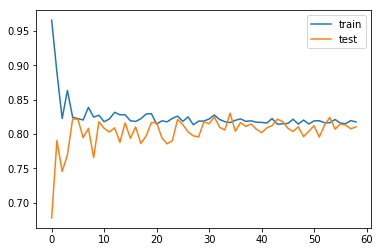

In [225]:
#filtering and plotting
n0 = 15
score_test = score_test[:(len(score_train) // n0) * n0 ]
plt.plot(filtering(score_train, n0), label = "train")
plt.plot(filtering(score_test, n0), label = "test")
plt.legend()